In [39]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm  import tqdm
from src.config import *
from sklearn.metrics import roc_auc_score

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
import liana as li

In [42]:
import scanpy as sc
import anndata

In [43]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

In [44]:
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

In [45]:
cellphone_results = glob('data/immunedict/ImmuneDict/cpdb_res_prop0'  + '/*')
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]

In [46]:
celltypes = pd.read_csv(cellphone_results[0], index_col=0).target.unique()

In [47]:
all_results = {}
for filename in tqdm(cellphone_results):
    pert_lrinteractions = pd.read_csv(filename, index_col = 0)
    pert = filename.split('/')[-1].split('.')[0].split(' ')[0]
    if pert == 'PBS':
        continue
    pert_lrinteractions['1-pval'] = 1- (pert_lrinteractions['cellphone_pvals'])
    pert_lrinteractions = pert_lrinteractions[(pert_lrinteractions['receptor_props'] > 0.1)] # & (pert_lrinteractions['ligand_props'] > 0.1)
    all_results[pert] = pert_lrinteractions[['ligand', 'receptor', 'source', 'target', 'cellphone_pvals', '1-pval']]

100%|██████████| 87/87 [00:44<00:00,  1.95it/s]


In [48]:
cytokine_annotation = pd.read_excel('data/immunedict/41586_2023_6816_MOESM3_ESM.xlsx')
cytokine_annotation['Cytokine'] = cytokine_annotation.Cytokine.str.replace('4-1BBL', '41BBL')
cytokine_annotation['Cytokine'] = cytokine_annotation.Cytokine.str.replace('IGF-1', 'IGF-I')
cytokine_annotation['Cytokine'] = cytokine_annotation.Cytokine.str.replace('LT-α1/β2', 'LTA1-B2')
cytokine_annotation['Cytokine'] = cytokine_annotation.Cytokine.str.replace('LT-α2/β1', 'LTA2-B1')
cytokine_annotation['Human gene symbol'] = cytokine_annotation['Human gene symbol'].str.replace('-', '')
cytokine_map = cytokine_annotation[['Cytokine', 'Human gene symbol']].dropna().set_index('Cytokine')['Human gene symbol'].to_dict()
cytokine_map['APRIL'] = 'TNFSF13B'

In [49]:
for pert in all_results.keys():
    all_results[pert]['true_value'] = all_results[pert]['ligand'].apply(
    lambda x: 1 if x in cytokine_map[pert].split(', ') else 0
)

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_56050/3022315007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
all_results.keys()

dict_keys(['LTA1-B2', 'IL-36Ra', 'FGF-β', 'EGF', 'OX40L', 'IFN-κ', 'Leptin', 'APRIL', 'IL-1Ra', 'NP', 'SCF', 'OSM', 'IL-17A', 'LIF', 'IL-11', 'IL-10', 'AdipoQ', 'IL-17B', 'IL-12', 'IL-13', 'LIGHT', 'IL-17C', 'IGF-I', 'VEGF', 'IL-Y', 'IL-9', 'BAFF', 'IL-36α', 'IL-1α', 'IL-17F', 'IL-17D', 'PRL', 'TNF-α', 'PSPN', 'IL-15', 'GM-CSF', 'GDNF', 'IL-1β', 'IL-17E', 'IL-18', 'IL-24', 'IL-7', 'IL-30', 'IL-31', 'IL-6', 'TSLP', 'IL-19', 'M-CSF', 'CD40L', 'IFN-α1', 'IL-33', 'IL-4', 'IL-27', 'IL-5', 'HGF', 'ADSF', 'IL-22', 'IL-23', 'TGF-β1', 'CT-1', 'TWEAK', 'Noggin', 'IL-2', 'IL-21', 'C5a', 'IL-34', 'IL-3', 'IL-20', 'LTA2-B1', 'IFN-λ2', 'TL1A', 'RANKL', 'IFN-ε', 'FLT3L', 'G-CSF', 'TPO', 'CD27L', 'FasL', 'Decorin', 'TRAIL', 'CD30L', 'GITRL', 'IFN-γ', 'C3a', 'IFN-β', '41BBL'])

In [51]:
pert = 'LTA1-B2'
print(cytokine_map['IL-17A'])

IL17A


In [52]:
# not available
print(len(all_results))
dropkeys = []
for pert in all_results.keys():
    if (all_results[pert]['true_value'] == 1).any():
        continue
    else:
        dropkeys.append(pert)

for key in dropkeys:
    all_results.pop(key, None)
print(len(all_results))

86
44


In [115]:

map_cells = {'B cell': 'B_cell',
 'ILC': 'ILC',
 'Mast_cell': 'Mast cell',
 'Macrophage': 'Macrophage',
 'MigDC': 'MigDC',
 'Monocyte': 'Monocyte',
 'NK cell': 'NK_cell',
 'Neutrophil': 'Neutrophil',
 'Langerhans': 'Langerhans',
 'CD4+ T cell': 'T_cell_CD4',
 'CD8+ T cell': 'T_cell_CD8',
 'γδ T cell': 'T_cell_gd',
 'Treg': 'Treg',
 'cDC1': 'cDC1',
 'cDC2': 'cDC2',
 'eTAC': 'eTAC',
 'pDC': 'pDC'}
degs = pd.read_excel('data/immunedict/41586_2023_6816_MOESM13_ESM.xlsx', sheet_name = 2)
nondegs = degs[(degs['nDEGs_display'] == '≤10')]
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('4-1BBL', '41BBL')
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('IGF-1', 'IGF-I')
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('LT-α1/β2', 'LTA1-B2')
nondegs['Cytokine'] = nondegs['Cytokine'].str.replace('LT-α2/β1', 'LTA2-B1')
nondegs['Celltype'] = nondegs['Celltype'].map(map_cells)
nondegs = nondegs.dropna(subset = ['Celltype'])

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_56050/1359092855.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_56050/1359092855.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_56050/1359092855.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [116]:
nondegs[nondegs['Cytokine'] == pert]['Celltype'].unique()

array(['T_cell_CD4', 'T_cell_CD8', 'T_cell_gd', 'Treg', 'ILC', 'pDC',
       'cDC1', 'cDC2', 'MigDC', 'Langerhans', 'eTAC', 'Macrophage',
       'Monocyte', 'Neutrophil'], dtype=object)

In [122]:
from sklearn.metrics import roc_auc_score

auc_scores = {}  

for pert in all_results.keys():
    if pert in nondegs.Cytokine.unique():
        cells = nondegs[nondegs['Cytokine'] == pert]['Celltype'].unique()
        allresults_pert_filtered = all_results[pert][~(all_results[pert]['source'].isin(cells) | all_results[pert]['target'].isin(cells))]
    else:
        allresults_pert_filtered = all_results[pert]
    true_values = allresults_pert_filtered['true_value'] 
    scores = allresults_pert_filtered['1-pval']  
    if len(set(true_values)) > 1:
        auc_scores[pert] = roc_auc_score(true_values, scores)
    else:
        auc_scores[pert] = None 
auc_scores = pd.Series(auc_scores).sort_values()

In [123]:
auc_scores.median()

np.float64(0.4038754736136038)

In [127]:
auc_scores.to_csv('results/revision/cellphonedb_immunedict_results_prop01_filtereddegs.csv')

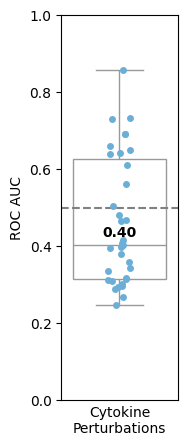

In [126]:
fig, ax = plt.subplots(figsize=(1.5, 5))
sns.boxplot(auc_scores, color = 'white')
sns.stripplot(auc_scores, color = '#6baed6')
plt.axhline(0.5, color = 'gray', linestyle = '--')
add_median_labels(ax)
plt.xticks([])
plt.ylabel('ROC AUC')
plt.ylim(0, 1)
plt.xlabel('Cytokine\nPerturbations')
plt.savefig('figures/revision/cellphonedb_immunedict_results_prop01_filtereddegs.pdf', bbox_inches = 'tight', dpi = 350)
plt.savefig('figures/revision/cellphonedb_immunedict_results_prop01_filtereddegs.png', bbox_inches = 'tight', dpi = 350)
plt.savefig('figures/revision/cellphonedb_immunedict_results_prop01_filtereddegs.jpg', bbox_inches = 'tight', dpi = 350)
plt.show()